In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 15000
stock = '9265'
gdf_filename_pattern = 'gdf_{}_' + 'len{}'.format(data_length) + '_r{}_s{}_K50'
gdf_parameters = [(1.0, 1.0), (0.1, 0.1), (0.1, 1.0), (1.0, 0.1)]

In [3]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, 
        gdf_filename_pattern=gdf_filename_pattern))

## Visualization

What do I want to say here?

* that data is quite random
* distribution of queue imbalance
* that there is some correlation between queue imbalance and mid price indicator 
* show some gdf values

In [4]:
df = gdf_dfs[2].df

### Mid Price

Data is quite random, there are outliers

Text(0.5,1,'Mid-Price for 9061 for training dataset')

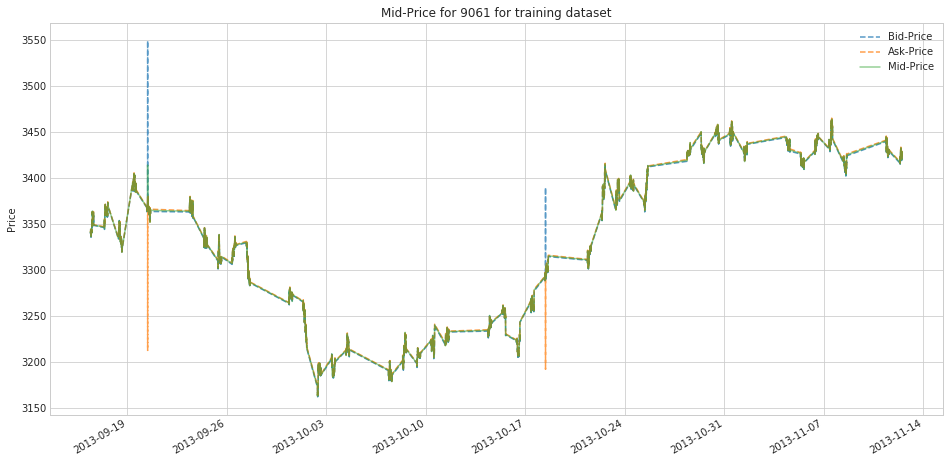

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))

df[['bid_price']].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].plot(ax=ax, alpha=0.5)
plt.legend(['Bid-Price', 'Ask-Price', 'Mid-Price',])
plt.ylabel('Price')
plt.xlabel('')
plt.title('Mid-Price for {} for training dataset'.format(stock))

We can observe outliers, lets look into them - both are around 11 Fridays

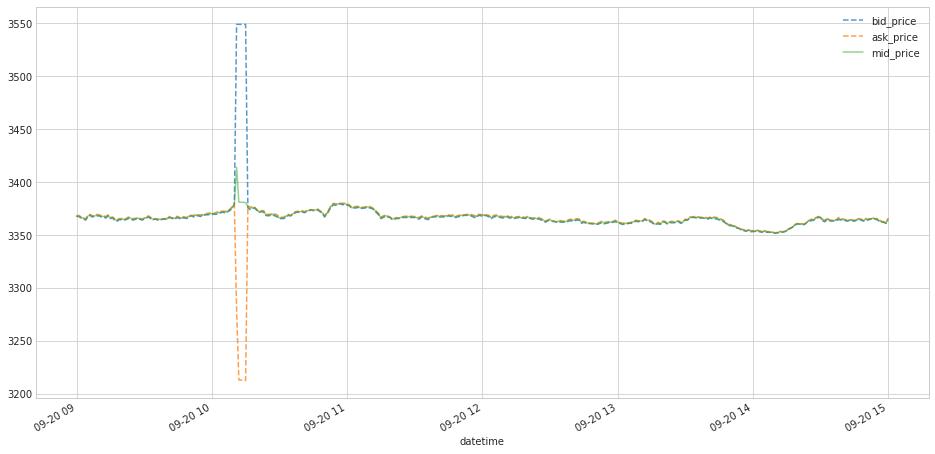

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
df[['bid_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.5)

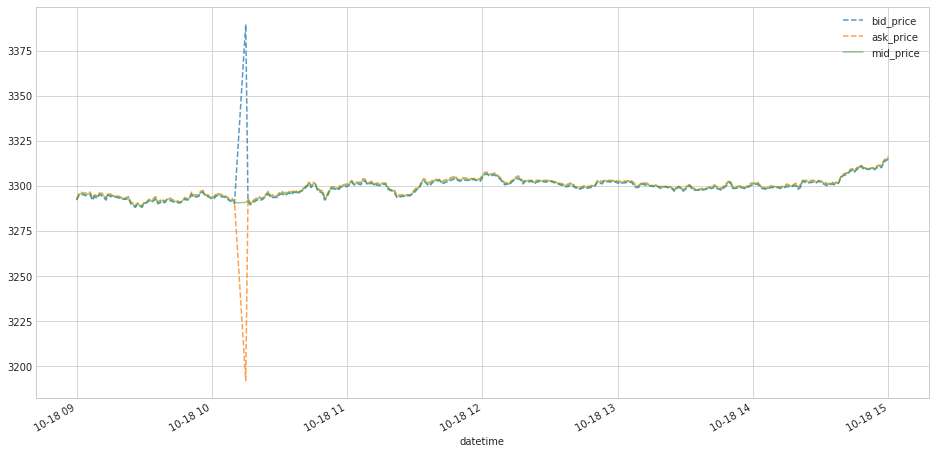

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
df[['bid_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.5)

### Distributions 

(3332.8806983915324, 3344.25, 0    3429.5
 dtype: float64)

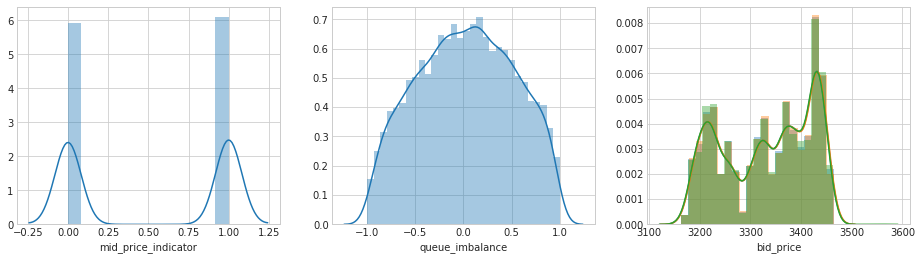

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.distplot(df['mid_price_indicator'], ax=ax[0])
sns.distplot(df['queue_imbalance'], ax=ax[1])
sns.distplot(df['mid_price'], ax=ax[2])
sns.distplot(df['ask_price'], ax=ax[2])
sns.distplot(df['bid_price'], ax=ax[2])
df['mid_price'].mean(), df['mid_price'].median(), df['mid_price'].mode()

Distribution of Mid-Price Indidcator is balanced (classes are balanced). Mid-Price distribution is slightly Right-Skewed.

(3332.8806983915324, 3344.25, 0    3429.5
 dtype: float64)

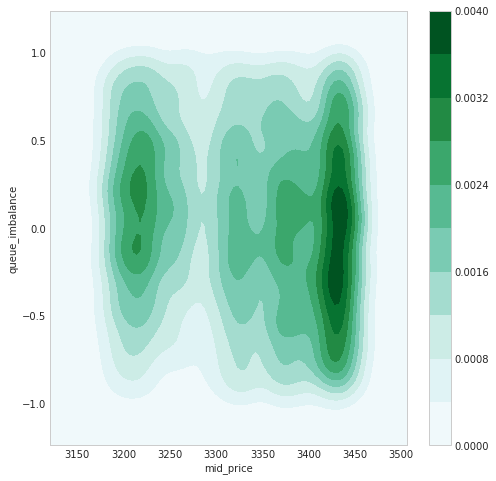

In [9]:
plt.figure(figsize=(8, 8))
sns.kdeplot(df['mid_price'], df['queue_imbalance'], cbar=True, shade=True)
df['mid_price'].mean(), df['mid_price'].median(), df['mid_price'].mode()

We can see that for queue imbalance -1 or 1 the density is the smallest. The highest density for queue imbalance in between -0.5 and 0.5 which happens to be around the mean mid price

### Correlations

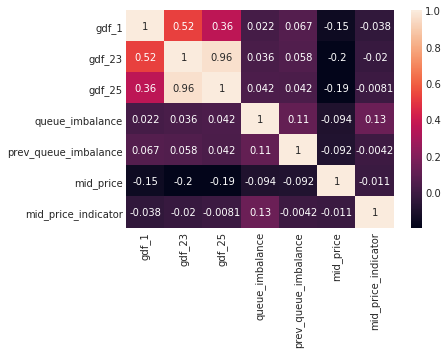

In [11]:
cols = ['gdf_1', 'gdf_23', 'gdf_25', 'queue_imbalance', 'prev_queue_imbalance', 
        'mid_price', 'mid_price_indicator']
sns.heatmap(df[cols].corr(), annot=True)
# TODO: ?

In [12]:
### GDF

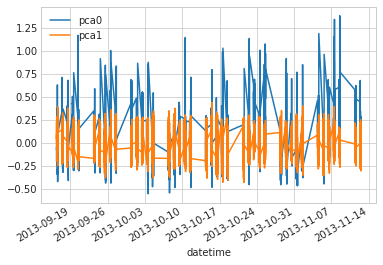

In [13]:
n_components = 2
pca = PCA(n_components=n_components)
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]
p = pca.fit_transform(df[gdf_columns])

for i in range(n_components):
    df['pca' + str(i)] = p[:, i]
pca_cols = ['pca' + str(i) for i in range(n_components)]

cols = ['gdf_23', 'gdf_25', 'queue_imbalance',
        'mid_price', 'mid_price_indicator']
df[pca_cols].plot()

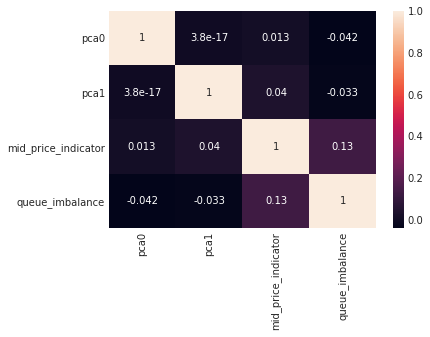

In [14]:

sns.heatmap(df[pca_cols + ['mid_price_indicator', 'queue_imbalance']].corr(), annot=True)

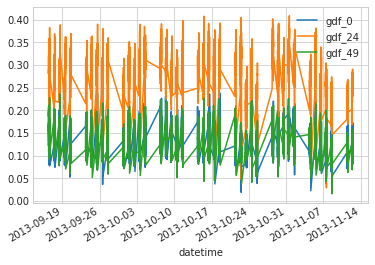

In [15]:
df[['gdf_0', 'gdf_24', 'gdf_49']].plot()

Text(0.5,1,'0.0')

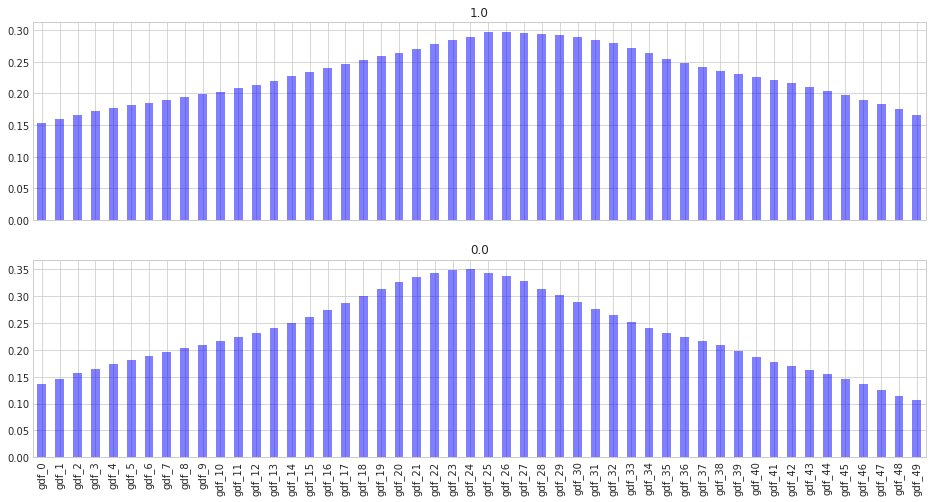

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
df[gdf_columns].iloc[0].plot('bar', color=['b'], alpha=0.5, ax=ax[0])
df[gdf_columns].iloc[2003].plot('bar', color=['b'], alpha=0.5, ax=ax[1])
ax[0].set_title(df['mid_price_indicator'].iloc[0])
ax[1].set_title(df['mid_price_indicator'].iloc[2003])

Text(0.5,1,'0.0')

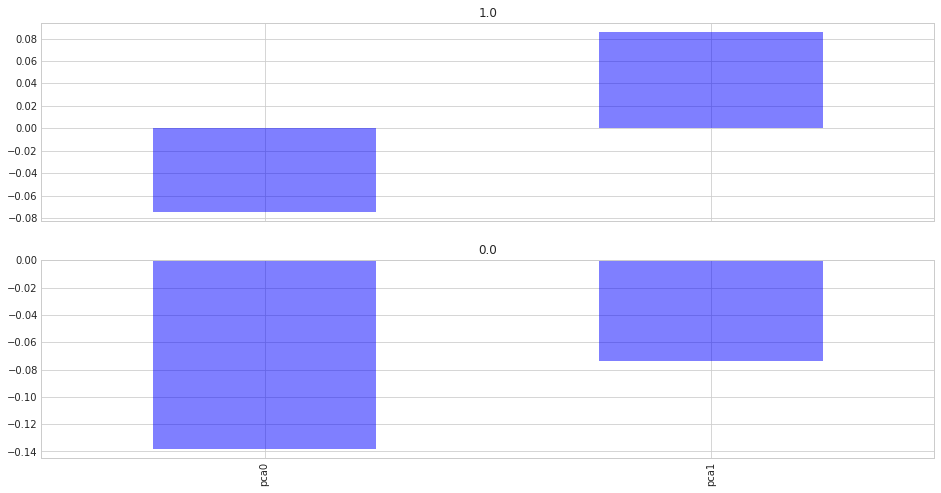

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
df[pca_cols].iloc[0].plot('bar', color=['b'], alpha=0.5, ax=ax[0])
df[pca_cols].iloc[2003].plot('bar', color=['b'], alpha=0.5, ax=ax[1])
ax[0].set_title(df['mid_price_indicator'].iloc[0])
ax[1].set_title(df['mid_price_indicator'].iloc[2003])

In [18]:
df.head()

,Unnamed: 0,gdf_0,gdf_1,gdf_10,gdf_11,gdf_12,gdf_13,gdf_14,gdf_15,gdf_16,...,gdf_9,mid_price,mid_price_indicator,datetime,bid_price,ask_price,queue_imbalance,prev_queue_imbalance,pca0,pca1
datetime,,,,,,,,,,,,,,,,,,,,,
2013-09-16 09:46:00,3001,0.152995,0.159949,0.202498,0.207833,0.213968,0.220107,0.226719,0.233740,0.240600,...,0.198514,3341.00,1.0,2013-09-16 09:46:00,3340.5,3341.5,-0.482974,-0.620313,-0.074567,0.085783
2013-09-16 09:48:00,3002,0.156184,0.164089,0.212918,0.218015,0.224363,0.231846,0.239701,0.248357,0.257112,...,0.207833,3341.75,0.0,2013-09-16 09:48:00,3341.0,3342.5,-0.440493,-0.482974,-0.139138,0.044611
2013-09-16 09:49:00,3003,0.148360,0.155876,0.200957,0.205445,0.210650,0.216103,0.222852,0.230167,0.238622,...,0.197527,3341.25,0.0,2013-09-16 09:49:00,3340.5,3342.0,-0.091036,-0.440493,-0.131013,0.126443
2013-09-16 09:50:00,3004,0.139671,0.149271,0.194084,0.198720,0.203530,0.209669,0.217216,0.225692,0.233156,...,0.190365,3341.00,1.0,2013-09-16 09:50:00,3340.5,3341.5,0.439182,-0.091036,-0.088110,0.144571
2013-09-16 09:52:00,3005,0.146863,0.154312,0.195380,0.199868,0.205665,0.212850,0.221502,0.230377,0.239046,...,0.192123,3341.25,0.0,2013-09-16 09:52:00,3340.5,3342.0,0.045593,0.439182,-0.094321,0.114518


Text(0,0.5,'')

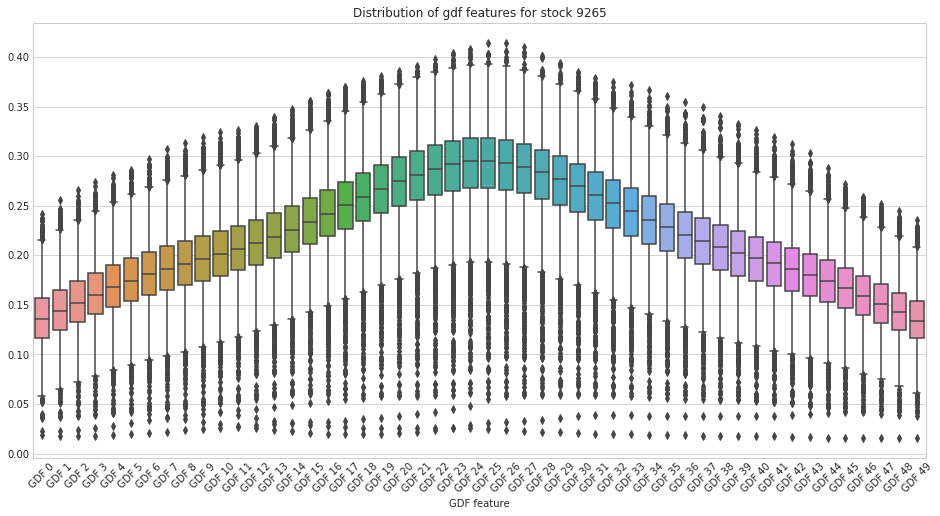

In [19]:
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=df[gdf_columns])

_ = ax.set_xticklabels([g.replace('_', ' ').upper() for g in gdf_columns], rotation=45)

plt.title('Distribution of gdf features for stock ' + str(stock))
plt.xlabel('GDF feature')
plt.ylabel('')

Text(0,0.5,'')

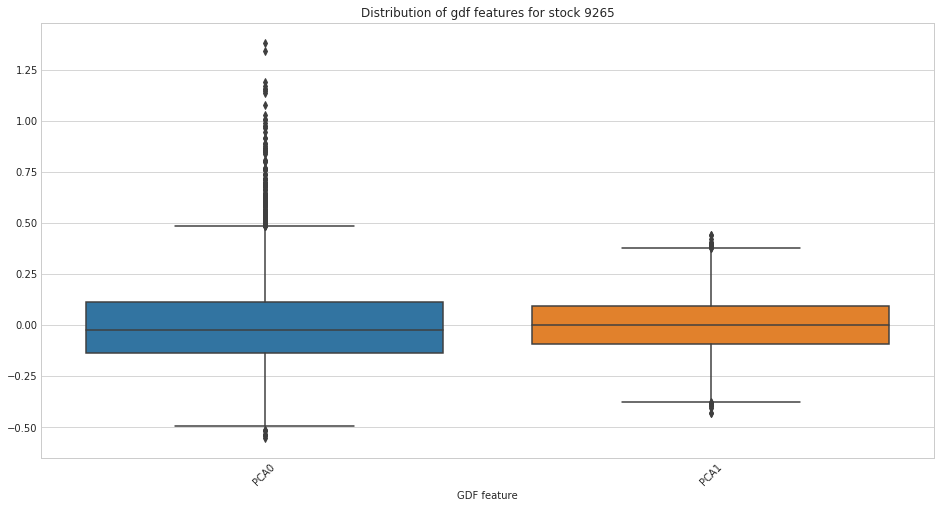

In [20]:
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=df[pca_cols])

_ = ax.set_xticklabels([g.replace('_', ' ').upper() for g in pca_cols], rotation=45)

plt.title('Distribution of gdf features for stock ' + str(stock))
plt.xlabel('GDF feature')
plt.ylabel('')

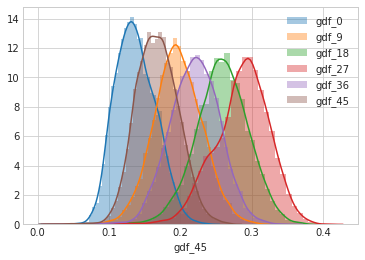

In [21]:
for g in gdf_columns[::9]:
    sns.distplot(df[g], label=g)
plt.legend()

## Predictions

In [33]:
def get_kernel_from_method(method):
    return method.split('_')[1]

class CFR():
    def __init__(self, clf, feature_name, is_svm=True):
        self.clf = clf
        self.feature_name = feature_name
        self.is_svm = is_svm

    def get_result(self, gdf_df, should_validate=False, method=None):
        if self.is_svm:
            return gdf_df.train_svm(C=self.clf.C, gamma=self.clf.gamma, coef0=self.clf.coef0, 
                                    kernel=self.clf.kernel, 
                                    feature_name=self.feature_name, should_validate=should_validate)
        else:
            res = gdf_df.train_log(self.clf, self.feature_name, should_validate=should_validate)
            if method:
                res['kernel'] = method
            return res

### Queue Imbalance - LOGIT, SVM (linear, rbf, sigmoid)

In [23]:
def get_best_svm_results_for_queue_imbalance(s, features):
    df_res = pd.read_csv('res_{}_prev_queue_imbalance.csv'.format(s))
    df_res= df_res[df_res['features'] == features]
    df_res= df_res[df_res['method'] != 'logistic']
    df_res['stock'] = [s for i in range(len(df_res))]
    columns_to_mean = ['f1', 'kappa', 'matthews', 
       'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']
    for c in columns_to_mean:
        cc = []
        for i, row in df_res.iterrows():
            from ast import literal_eval
            cc.append(np.array(literal_eval(row[c])).mean())
        df_res[c] = cc

    return df_res.sort_values(by='matthews', ascending=False).groupby('method').head(1)

In [24]:
df_best_svm_que = get_best_svm_results_for_queue_imbalance(stock, features='queue_imbalance')

In [25]:
log_que_clfs = [
    CFR(clf=LogisticRegression(), feature_name='que', is_svm=False),
]

svm_que_clfs = [
    CFR(
        SVC(kernel=get_kernel_from_method(row['method']), 
            C=row['c'], 
            gamma=row['gamma'], 
            coef0=row['coef0']), feature_name='que') 
                for i, row in df_best_svm_que.iterrows()]


In [31]:
res = []
for clf in log_que_clfs + svm_que_clfs:
    r = clf.get_result(gdf_dfs[0])
    res.append(r)
df_res_que = pd.DataFrame(res)
df_res_que

,C,coef0,features,gamma,kernel,stock,test_f1,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,NaN,NaN,que,NaN,logistic,9265,0.568101,0.109649,0.109843,0.552201,0.584943,0.554821,0.574561,0.106338,0.106592,0.556308,0.594053,0.553116
1,1.0,1.0,que,0.1,sigmoid,9265,0.533145,0.117136,0.117860,0.566292,0.503664,0.558574,0.534607,0.107998,0.108654,0.567060,0.505668,0.554086
2,1.0,NaN,que,0.1,rbf,9265,0.618182,0.117432,0.123469,0.545316,0.713524,0.558698,0.620498,0.108902,0.114518,0.548273,0.714638,0.554207
3,0.1,NaN,que,NaN,linear,9265,0.565643,0.113001,0.113092,0.554773,0.576949,0.556498,0.568596,0.107232,0.107313,0.558158,0.579432,0.553586


### Queue Imbalance and Prev Queue Imbalance

In [27]:
df_best_svm_prev_que = get_best_svm_results_for_queue_imbalance(
    stock, features='queue_imbalance, prev_queue_imbalance')

In [28]:
prev_que_log_clfs = [
    CFR(clf=LogisticRegression(), feature_name='que_prev', is_svm=False),
]

svm_prev_que_clfs = [
    CFR(
        SVC(kernel=get_kernel_from_method(row['method']), 
            C=row['c'], 
            gamma=row['gamma'], 
            coef0=row['coef0']), feature_name='que_prev') 
                for i, row in df_best_svm_prev_que.iterrows()]

In [29]:
res = []
for clf in prev_que_log_clfs + svm_prev_que_clfs:
    r = clf.get_result(gdf_dfs[0])
    res.append(r)
df_res_que_prev = pd.DataFrame(res)
df_res_que_prev

,C,coef0,features,gamma,kernel,stock,test_f1,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,NaN,NaN,que_prev,NaN,logistic,9265,0.569677,0.110311,0.110547,0.552220,0.588274,0.555152,0.574996,0.108202,0.108444,0.557268,0.593889,0.554049
1,100.0,0.1,que_prev,0.01,sigmoid,9265,0.555702,0.101014,0.101037,0.549902,0.561626,0.550506,0.564207,0.108706,0.108718,0.560052,0.568425,0.554341
2,1.0,NaN,que_prev,0.01,rbf,9265,0.567990,0.114328,0.114460,0.554990,0.581612,0.557161,0.572752,0.107314,0.107495,0.557265,0.589124,0.553612
3,0.1,NaN,que_prev,NaN,linear,9265,0.564606,0.112337,0.112413,0.554627,0.574950,0.556167,0.568164,0.104853,0.104946,0.556870,0.579924,0.552395


### GDF Plain

In [ ]:
df_gdf_plain_res = pd.DataFrame()
gdf_results_dir = '../gaussian_filter/data_res_9061_len15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_plain_res = df_gdf_plain_res.append(temp_df)
print(df_gdf_plain_res.columns)
df_gdf_plain_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(1)

In [ ]:
r = 1.0
s = 0.1
C = 1.0 
gamma = 10000.0
filename = 'data_gdf/gdf_{}_len{}_r{}_s{}_K{}.csv'.format(stock, length, r, s, K)

### GDF with PCA

In [30]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca_gdf3_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

,Unnamed: 0,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
5,5,100.0,NaN,0.558709,pca_gdf_que3,NaN,0.113326,linear,0.114112,0.567350,...,0.117736,0.560298,0.550966,0.558861,0.559129,0.116163,0.116271,0.555976,0.562796,0.558050
4,4,10.0,NaN,0.558933,pca_gdf_que3,NaN,0.113303,linear,0.114065,0.567310,...,0.117067,0.559919,0.550966,0.558527,0.559637,0.116970,0.117079,0.556401,0.563383,0.558453
29,29,10.0,NaN,0.559908,pca_gdf_que3,0.010,0.111066,rbf,0.111811,0.565592,...,0.122516,0.558360,0.589607,0.561159,0.557287,0.112944,0.113390,0.554743,0.561882,0.556402
42,42,1000.0,NaN,0.558846,pca_gdf_que3,0.001,0.110710,rbf,0.111481,0.565576,...,0.119808,0.557460,0.584943,0.559828,0.556774,0.112674,0.113112,0.554630,0.560949,0.556268
18,18,100.0,0.01,0.560066,pca_gdf_que3,0.010,0.110094,sigmoid,0.110732,0.564871,...,0.114377,0.557937,0.554963,0.557188,0.557534,0.112695,0.112801,0.554264,0.561307,0.556315
19,19,100.0,1.00,0.562024,pca_gdf_que3,0.010,0.110002,sigmoid,0.110589,0.563868,...,0.115271,0.565283,0.499001,0.557244,0.559631,0.112175,0.112259,0.553303,0.566366,0.556101


In [ ]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca1_gdf_que_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

In [ ]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca2_gdf_que_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

In [39]:
from sklearn.neural_network import MLPClassifier
alphas = [0.01, 0.1, 1.0]
activations = ['tanh']
solvers = ['adam']
hidden_layer_sizes = [(3, 3), (10, 3), (3, 10), (10, 10)]
features = ['pca_gdf_que_prev3', 'pca_gdf_que_prev5']
res1 = []

for feature in features:
    for hidden_layer_size in hidden_layer_sizes:
        for solver in solvers:
            for activation in activations:
                for alpha in alphas:
                    clf = MLPClassifier(solver=solver, alpha=alpha, activation=activation,
                                              hidden_layer_sizes=hidden_layer_size, random_state=1)

                    c = CFR(clf=clf, feature_name=feature, is_svm=False)
                    r = c.get_result(gdf_dfs[0], should_validate=True, method='mlp')
                    res1.append({**r, 'hidden_layer_size': hidden_layer_size, 
                                'alpha': alpha, 'activation': activation, 'solver': solver})
pd.DataFrame(res1)

,activation,alpha,f1,features,hidden_layer_size,kappa,kernel,matthews,precision,recall,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,tanh,0.01,0.564416,pca_gdf_que_prev3,"(3, 3)",0.102600,mlp,0.103416,0.558468,0.574189,...,0.116398,0.559540,0.550966,0.558193,0.565342,0.110220,0.110758,0.551180,0.581908,0.555052
1,tanh,0.10,0.563454,pca_gdf_que_prev3,"(3, 3)",0.102624,mlp,0.103411,0.558706,0.571977,...,0.120385,0.561156,0.556296,0.560191,0.564331,0.109511,0.110017,0.550915,0.580020,0.554699
2,tanh,1.00,0.551129,pca_gdf_que_prev3,"(3, 3)",0.099040,mlp,0.099892,0.559557,0.547344,...,0.105862,0.555944,0.529647,0.552874,0.554776,0.110309,0.110662,0.553669,0.557530,0.555091
3,tanh,0.01,0.532101,pca_gdf_que_prev3,"(10, 3)",0.107767,mlp,0.109334,0.570674,0.502095,...,0.114772,0.565749,0.493005,0.556916,0.532447,0.114318,0.115037,0.562213,0.506440,0.557097
4,tanh,0.10,0.532676,pca_gdf_que_prev3,"(10, 3)",0.106995,mlp,0.108484,0.570010,0.503466,...,0.112787,0.564751,0.491006,0.555917,0.533224,0.113860,0.114543,0.561683,0.508354,0.556866
5,tanh,1.00,0.545580,pca_gdf_que_prev3,"(10, 3)",0.099739,mlp,0.100493,0.561506,0.533947,...,0.111040,0.554902,0.565623,0.555508,0.549121,0.112812,0.113175,0.556870,0.543157,0.556337
6,tanh,0.01,0.548410,pca_gdf_que_prev3,"(3, 10)",0.107159,mlp,0.108419,0.566033,0.537035,...,0.127940,0.574785,0.489007,0.563262,0.552528,0.112618,0.112866,0.555648,0.550642,0.556252
7,tanh,0.10,0.548635,pca_gdf_que_prev3,"(3, 10)",0.107383,mlp,0.108685,0.566042,0.537696,...,0.128856,0.576190,0.483678,0.563601,0.553346,0.113899,0.114142,0.556227,0.551660,0.556894
8,tanh,1.00,0.552707,pca_gdf_que_prev3,"(3, 10)",0.101668,mlp,0.102497,0.561195,0.548450,...,0.108365,0.554161,0.558961,0.554180,0.555359,0.113199,0.113617,0.555537,0.557137,0.556526
9,tanh,0.01,0.548273,pca_gdf_que_prev3,"(10, 10)",0.106699,mlp,0.107801,0.565599,0.536676,...,0.111276,0.552109,0.592938,0.555481,0.549108,0.110844,0.111299,0.555545,0.544932,0.555352


In [41]:
df_res1 = pd.DataFrame(res1)
df_res1.sort_values(by='test_matthews', ascending=False).head()

,activation,alpha,f1,features,hidden_layer_size,kappa,kernel,matthews,precision,recall,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
18,tanh,0.01,0.537640,pca_gdf_que_prev5,"(3, 10)",0.108841,mlp,0.110567,0.570867,0.513531,...,0.129128,0.574864,0.493671,0.563925,0.542989,0.112808,0.113389,0.558404,0.530669,0.556325
7,tanh,0.10,0.548635,pca_gdf_que_prev3,"(3, 10)",0.107383,mlp,0.108685,0.566042,0.537696,...,0.128856,0.576190,0.483678,0.563601,0.553346,0.113899,0.114142,0.556227,0.551660,0.556894
6,tanh,0.01,0.548410,pca_gdf_que_prev3,"(3, 10)",0.107159,mlp,0.108419,0.566033,0.537035,...,0.127940,0.574785,0.489007,0.563262,0.552528,0.112618,0.112866,0.555648,0.550642,0.556252
22,tanh,0.10,0.541886,pca_gdf_que_prev5,"(10, 10)",0.111793,mlp,0.112906,0.570725,0.519078,...,0.122417,0.568148,0.510993,0.560904,0.546523,0.115665,0.116014,0.559292,0.535525,0.557774
1,tanh,0.10,0.563454,pca_gdf_que_prev3,"(3, 3)",0.102624,mlp,0.103411,0.558706,0.571977,...,0.120385,0.561156,0.556296,0.560191,0.564331,0.109511,0.110017,0.550915,0.580020,0.554699


In [34]:
from sklearn.neural_network import MLPClassifier
alphas = [0.0001, 0.001, 0.1, 1.0] # sgd with alpha = 1
activations = ['identity', 'logistic', 'tanh', 'relu']
solvers = ['adam', 'sgd']
hidden_layer_sizes = [(3, 3), (10, 3), (3, 10), (10, 10)]

res = []

for hidden_layer_size in hidden_layer_sizes:
    for solver in solvers:
        for activation in activations:
            for alpha in alphas:
                clf = MLPClassifier(solver=solver, alpha=alpha, activation=activation,
                                          hidden_layer_sizes=hidden_layer_size, random_state=1)

                c = CFR(clf=clf, feature_name='pca_gdf_que_prev10', is_svm=False)
                r = c.get_result(gdf_dfs[0], should_validate=True, method='mlp')
                res.append({**r, 'hidden_layer_size': hidden_layer_size, 
                            'alpha': alpha, 'activation': activation, 'solver': solver})
pd.DataFrame(res)

,activation,alpha,f1,features,hidden_layer_size,kappa,kernel,matthews,precision,recall,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,identity,0.0001,0.542099,pca_gdf_que_prev10,"(3, 3)",0.100629,mlp,0.101607,0.563315,0.526167,...,0.111102,0.557534,0.542305,0.555532,0.546037,0.109661,0.110018,0.555170,0.538929,0.554766
1,identity,0.0010,0.542101,pca_gdf_que_prev10,"(3, 3)",0.100643,mlp,0.101623,0.563324,0.526167,...,0.111772,0.557916,0.542305,0.555866,0.545961,0.109522,0.109879,0.555103,0.538848,0.554696
2,identity,0.1000,0.540072,pca_gdf_que_prev10,"(3, 3)",0.097424,mlp,0.098403,0.561547,0.524046,...,0.114464,0.559614,0.540973,0.557202,0.545283,0.109089,0.109457,0.555016,0.537640,0.554479
3,identity,1.0000,0.543941,pca_gdf_que_prev10,"(3, 3)",0.097018,mlp,0.098234,0.560553,0.534027,...,0.109709,0.554107,0.566289,0.554840,0.547983,0.107855,0.108374,0.553470,0.545468,0.553850
4,logistic,0.0001,0.354292,pca_gdf_que_prev10,"(3, 3)",0.006062,mlp,0.005950,0.289914,0.486134,...,0.000000,0.500500,1.000000,0.500000,0.342778,0.003620,0.003358,0.283042,0.469532,0.501808
5,logistic,0.0010,0.353975,pca_gdf_que_prev10,"(3, 3)",0.006141,mlp,0.006048,0.290013,0.485563,...,0.000000,0.500500,1.000000,0.500000,0.342702,0.003585,0.003324,0.283025,0.469430,0.501791
6,logistic,0.1000,0.320200,pca_gdf_que_prev10,"(3, 3)",0.007289,mlp,0.009236,0.295028,0.414240,...,0.000000,0.500500,1.000000,0.500000,0.305909,0.005681,0.006684,0.286013,0.398089,0.502839
7,logistic,1.0000,0.226473,pca_gdf_que_prev10,"(3, 3)",0.000000,mlp,0.000000,0.171560,0.333333,...,0.000000,0.500500,1.000000,0.500000,0.224314,0.000000,0.000000,0.169032,0.333333,0.500000
8,tanh,0.0001,0.534946,pca_gdf_que_prev10,"(3, 3)",0.094323,mlp,0.095404,0.558649,0.523216,...,0.118408,0.557705,0.576282,0.559169,0.545101,0.113739,0.115329,0.559787,0.539112,0.556751
9,tanh,0.0010,0.535151,pca_gdf_que_prev10,"(3, 3)",0.094718,mlp,0.095798,0.558834,0.523409,...,0.117743,0.557345,0.576282,0.558835,0.544919,0.113590,0.115175,0.559678,0.538928,0.556677


In [35]:
df_res = pd.DataFrame(res)
df_res.sort_values(by='matthews', ascending=False).groupby('solver').head(2)

,activation,alpha,f1,features,hidden_layer_size,kappa,kernel,matthews,precision,recall,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
110,relu,0.1,0.536336,pca_gdf_que_prev10,"(10, 10)",0.108056,mlp,0.109512,0.569578,0.511055,...,0.120126,0.573432,0.463025,0.558949,0.539814,0.120187,0.120883,0.564510,0.518494,0.560023
74,tanh,0.1,0.554100,pca_gdf_que_prev10,"(3, 10)",0.107822,mlp,0.108825,0.565157,0.547740,...,0.114161,0.562409,0.516322,0.556893,0.555169,0.112316,0.112599,0.554751,0.556948,0.556103
123,tanh,1.0,0.554413,pca_gdf_que_prev10,"(10, 10)",0.106208,mlp,0.107228,0.563635,0.550192,...,0.113556,0.562454,0.512991,0.556562,0.547681,0.107969,0.108406,0.553376,0.544733,0.553917
58,tanh,0.1,0.558805,pca_gdf_que_prev10,"(10, 3)",0.103327,mlp,0.103827,0.561022,0.559109,...,0.114008,0.571672,0.446369,0.555628,0.554962,0.107817,0.107949,0.551953,0.558601,0.553871


In [38]:
df_res[['activation', 'alpha', 'solver', 'matthews', 'hidden_layer_size']].sort_values(
    by='matthews', ascending=False)

,activation,alpha,solver,matthews,hidden_layer_size
110,relu,0.1000,adam,0.109512,"(10, 10)"
74,tanh,0.1000,adam,0.108825,"(3, 10)"
66,identity,0.1000,adam,0.108815,"(3, 10)"
34,identity,0.1000,adam,0.108534,"(10, 3)"
98,identity,0.1000,adam,0.108362,"(10, 10)"
123,tanh,1.0000,sgd,0.107228,"(10, 10)"
97,identity,0.0010,adam,0.106948,"(10, 10)"
96,identity,0.0001,adam,0.106947,"(10, 10)"
104,tanh,0.0001,adam,0.106559,"(10, 10)"
99,identity,1.0000,adam,0.106522,"(10, 10)"
